In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt

from notebook_client.notebook_client import NotebookClient

In [2]:
nc = NotebookClient()
nc.initialize_producers_manager_connection()
nc.initialize_sampler_manager_connection()

In [3]:
producer_pid = nc.start_streaming('in_topic', { 'locations': '-74,40,-73,41' })

In [4]:
reservoir_size = 5
limit = 20
nc.start_sampling('in_topic', 'out_topic', reservoir_size, limit)

In [5]:
nc.streaming_status(producer_pid)

'running'

In [6]:
nc.sampling_status()

'running'

In [6]:
nc.stop_streaming(producer_pid)

'stopped'

In [7]:
from kafka import KafkaConsumer

consumer = KafkaConsumer('out_topic', bootstrap_servers='kafka')
consumer.topics()
partition = consumer.assignment().pop()

In [8]:
consumer.seek_to_end()

In [9]:
end = consumer.position(partition)
consumer.seek(partition, end - reservoir_size)

In [10]:
consumer.position(partition)

0

In [11]:
get_value = lambda c: c.__next__().value.decode('utf-8')
data = [get_value(consumer) for i in range(reservoir_size)]

In [12]:
parsed_data = list(map(lambda x: json.loads(x), data))

In [13]:
df = pd.DataFrame.from_records(data=parsed_data)
df['created_at'] = pd.to_datetime(df['created_at'])
df.index = df.created_at
del df['created_at']

In [28]:
df

,text,user_favourites_count,user_friends_count,user_id,user_name,user_verified
created_at,,,,,,
2017-07-26 19:46:15,"See our latest #NewYork, NY #job and click to ...",0,326,20832061,NYC Sales Jobs,False
2017-07-26 19:46:20,Just posted a photo @ Lower East Side https://...,539,787,750370596,BK 1,False
2017-07-26 19:46:26,Este domingo llegamos a sahara_cafe con el dal...,471,1622,28223933,El Klan Perfecto,False
2017-07-26 19:46:35,What do you call a self-absorbed lobster?\n\nA...,3972,131,843528421284233220,"wil, son.",False
2017-07-26 19:46:36,Well firing Mueller will be the nail in his lo...,43151,25916,739844197935644672,Andrew Wortman,False


In [14]:
df.describe()

,user_favourites_count,user_friends_count,user_id
count,5.000000,5.000000,5.000000e+00
mean,206.200000,236.800000,1.636778e+08
std,283.799577,102.238447,2.335048e+08
min,0.000000,101.000000,1.828650e+07
25%,0.000000,156.000000,2.572243e+07
50%,0.000000,284.000000,7.172096e+07
75%,475.000000,310.000000,1.287928e+08
max,556.000000,333.000000,5.738664e+08


In [15]:
#text_lengths = df.text.map(lambda x: len(x.split(' ')))
text_lengths = df.text.map(len)

In [16]:
text_lengths.describe()

count      5.000000
mean      99.200000
std       45.091019
min       45.000000
25%       55.000000
50%      129.000000
75%      133.000000
max      134.000000
Name: text, dtype: float64

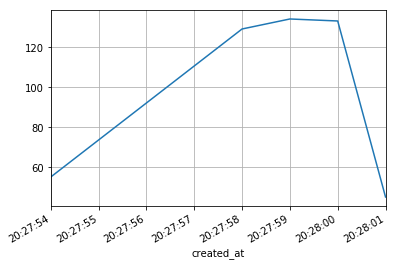

In [17]:
text_lengths.plot(grid=True)
plt.show()

In [18]:
import pyspark

sc = pyspark.SparkContext('local[*]')
sqlc = pyspark.sql.SQLContext(sc)

In [19]:
spark_df = sqlc.createDataFrame(df)

In [20]:
import pyspark.mllib.regression as mllib_reg
import pyspark.mllib.linalg as mllib_lalg
import pyspark.mllib.classification as mllib_class

In [21]:
data_labeled = spark_df.rdd.map(lambda fields: mllib_reg.LabeledPoint(fields[-1], mllib_lalg.Vectors.dense(fields[2:4])))

In [22]:
train, test = data_labeled.randomSplit([0.65, 0.35], seed = 13)

In [23]:
nbay = mllib_class.NaiveBayes.train(train, 1.0)

In [24]:
predictionAndLabel = test.map(lambda p : (nbay.predict(p.features), p.label))

In [25]:
testErr = predictionAndLabel.filter(lambda x: x[0] != x[1]).count() / test.count()
accuracy = 100.0 * predictionAndLabel.filter(lambda x: x[0] == x[1]).count() / test.count()

In [26]:
print('Accuracy: {0}%'.format(accuracy))

Accuracy: 50.0%


In [27]:
nbay